In [1]:
from utils_nlp import Tools
tools = Tools('mhk9c')

installing package 1
installing package 2
installing package 3
installing package 4
installing package 5
installing package 6
installing package 7
Done Installing packages


In [2]:
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
import sparknlp
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.clustering import LDA

# from pyspark.sql.functions import *
from pyspark.sql import functions as F
import plotly.graph_objects as go
import plotly.express as px

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import pandas as pd

figure(figsize=(16, 8), dpi=80)

<Figure size 1280x640 with 0 Axes>

In [3]:
spark = sparknlp.start()

### Loading Data

In [4]:
_df = tools.load_data(spark, "russian-troll-tweets-enriched")
_df = _df.withColumn("publish_date_timestamp",F.to_timestamp(F.col("publish_date"),"M/d/yyyy H:mm"))
_df = _df.withColumn("publish_date_date",F.to_date(F.col("publish_date_timestamp")))
_df = _df.withColumn("publish_hour", F.hour(F.col("publish_date_timestamp")))

_df = _df.filter((_df["publish_date_date"] >= F.lit("2014-10-14")) & (_df["publish_date_date"] <= F.lit("2017-12-14"))) 

df_troll = _df.filter(_df['label']==1)
df_ltroll = _df.filter(_df['account_category']=="LeftTroll")
df_rtroll = _df.filter(_df['account_category']=="RightTroll")
df_nontroll = _df.filter(_df['label']==0)

Done loading from /project/ds5559/team1_sp22/data//russian-troll-tweets-enriched.


In [5]:
print(df_troll.count())
print(df_ltroll.count())
print(df_rtroll.count())
print(df_nontroll.count())

1113824
409003
693838
975722


### Hashes Frequency

In [ ]:
def make_word_cloud(_df, filename="test"):    

    figure(figsize=(16, 8), dpi=80)
    troll_hashes_df = _df
    troll_hashes_df = troll_hashes_df.withColumn("hash", F.explode(troll_hashes_df.hashes))
    troll_hashes_df_groups = troll_hashes_df.groupBy("hash").count().sort("count", ascending=False)
    troll_hashes_df_groups.show(20, False)

    hash_df = troll_hashes_df_groups.limit(100).toPandas()
    hash_dict = dict(hash_df.values)
    wordcloud = WordCloud(width=1000,height=500, max_words=100,relative_scaling=.5,normalize_plurals=False, background_color="white").generate_from_frequencies(hash_dict)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
#     plt.write_image(f"images/{filename}.png")
    plt.savefig(f'images/{filename}.png')
    plt.show()

### All Trolls

In [ ]:
make_word_cloud(df_troll.select("hashes"), "all_trolls")

#### Left Trolls

In [ ]:
troll_hashes_df = df_troll.filter(df_troll.account_category == "LeftTroll").select("hashes")
make_word_cloud(troll_hashes_df, "left_trolls")

#### Right Trolls

In [ ]:
troll_hashes_df = df_troll.filter(df_troll.account_category == "RightTroll").select("hashes")
make_word_cloud(troll_hashes_df, "right_trolls")

#### Non Trolls

In [ ]:
nontroll_hashes_df = df_nontroll.select("hashes")
make_word_cloud(nontroll_hashes_df, "non_trolls")

### Show activity by date


In [ ]:
df_groups = _df.groupBy("label","publish_date_date").count().sort("publish_date_date", ascending=True)

In [ ]:
df_groups_p = df_groups.toPandas()
df_groups_p.head()

In [ ]:
fig = px.line(df_groups_p, x='publish_date_date', y="count", facet_col="label", facet_col_wrap=2)
fig.show()

In [ ]:
df_groups_troll = df_troll.groupBy("publish_date_date").count().sort("publish_date_date", ascending=True)
df_groups_troll_p = df_groups_troll.toPandas()

df_groups_nontroll = df_nontroll.groupBy("publish_date_date").count().sort("publish_date_date", ascending=True)
df_groups_nontroll_p = df_groups_nontroll.toPandas()

In [ ]:
def add_line_to_fig(fig, df, x, y, y_field, color, label, dash='solid'):    
    figure(figsize=(16, 8), dpi=80)
    fig.add_trace(go.Scatter(                            
                            x=x,
                            y=y,
                            mode='lines',
                            name=label,
                            hovertext=df[y_field],
                            line=dict(color=color, dash=dash)
            ))   

fig_new = go.Figure()
add_line_to_fig(fig_new, df_groups_troll_p, df_groups_troll_p['publish_date_date'], df_groups_troll_p['count'], "count", "darkseagreen", "Troll" )
add_line_to_fig(fig_new, df_groups_nontroll_p, df_groups_nontroll_p['publish_date_date'], df_groups_nontroll_p['count'], "count", "darkslategray", "Non Troll" )
fig_new.update_layout(title_text='Troll / Non-Troll Tweet Frequency', title_x=0.5)
fig_new.show()

fig_new.write_image("images/frequencies_over_time.png")

In [ ]:
sa_pipeline = PretrainedPipeline("analyze_sentimentdl_use_twitter", lang = "en") 

### Sentiment Analysis

In [48]:
def run_sentiment(_df, name):
    _df = _df.withColumn("text", F.col("content"))
    processed_df  = sa_pipeline.transform(_df)
    result_df = processed_df.select('sentiment.result', 'publish_date_date')
    result_exploded_df = result_df.withColumn("eresult", F.explode(result_df.result))
    sentiment_groups_df = result_exploded_df.groupBy("publish_date_date", "eresult").count().sort("count", ascending=False)
    print("Saving Spark df to Parquet")
    tools.save_df(spark, sentiment_groups_df, name)
    print("Converting to Pandas")
    sentiment_groups_df_p = sentiment_groups_df.toPandas()
    print("Saving Pandas to parquet")
    sentiment_groups_df_p.to_parquet(f'/project/ds5559/team1_sp22/data/{name}_pandas')

def load_pandas(name):
    return pd.read_parquet(f'/project/ds5559/team1_sp22/data/{name}_pandas')

def make_figures(_df, title):
    
    color_discrete_map = {'positive': 'rgb(31, 119, 180)', 'negative': 'rgb(214, 39, 40)', 'neutral': 'lightseagreen'}
#     fig = px.scatter(df[df.species.isin(['virginica', 'setosa'])], x="sepal_width", y="sepal_length", color="species", color_discrete_map=color_discrete_map)
    
    
    fig = px.bar(_df, x='publish_date_date', y='count', color='eresult',
                 labels={
                     "publish_date_date": "Date",
                     "count": "Number of Tweets",
                     "eresult": "Sentiment"
                 },
                 color_discrete_map=color_discrete_map
    )
    fig.update_layout(title_text=f"{title} Sentiment Over time", title_x=0.5)
    fig.update_traces(dict(marker_line_width=0))
    fig.show()
    
    groups_df = _df.groupby("eresult", as_index=False)["count"].sum()
    fig_general = px.bar(groups_df, x='eresult', y='count')
    fig_general.update_layout(title_text=f"{title} Distribution", title_x=0.5)
    fig_general.show()   


### Left Trolls

In [10]:
name = "left_trolls"
# run_sentiment(df_ltroll, name)
_left_trolls_df = load_pandas(name)

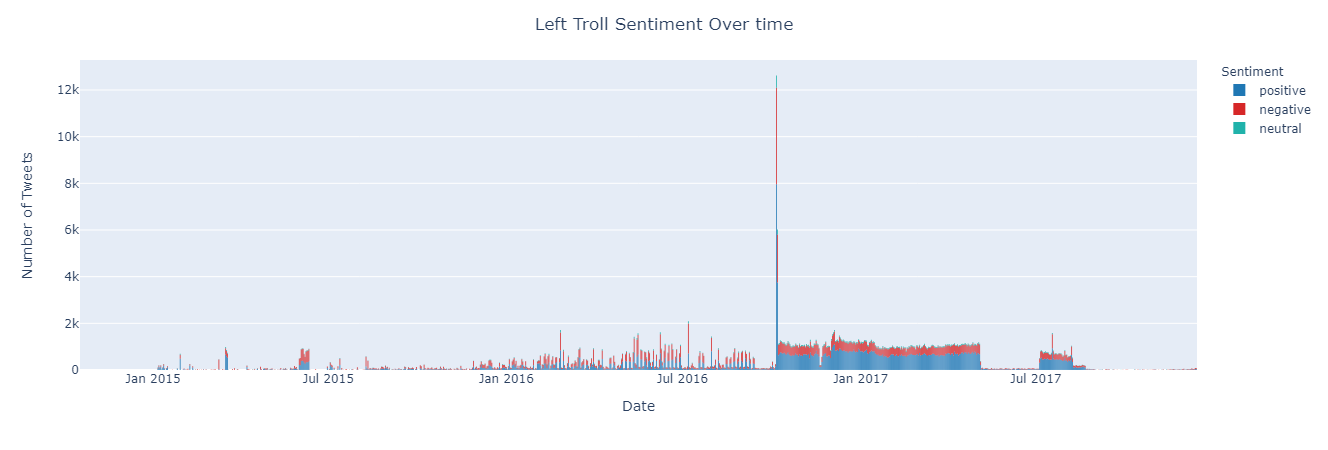

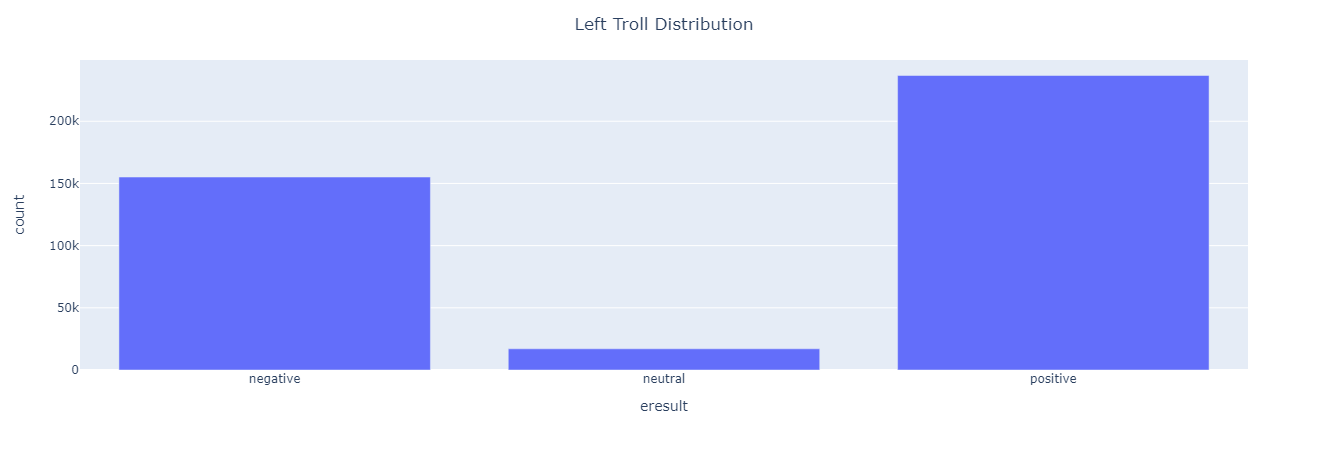

In [49]:
make_figures(_left_trolls_df, "Left Troll")

### Right Trolls

In [11]:
name = "right_trolls"
# run_sentiment(df_rtroll, name)
_right_trolls_df = load_pandas(name)

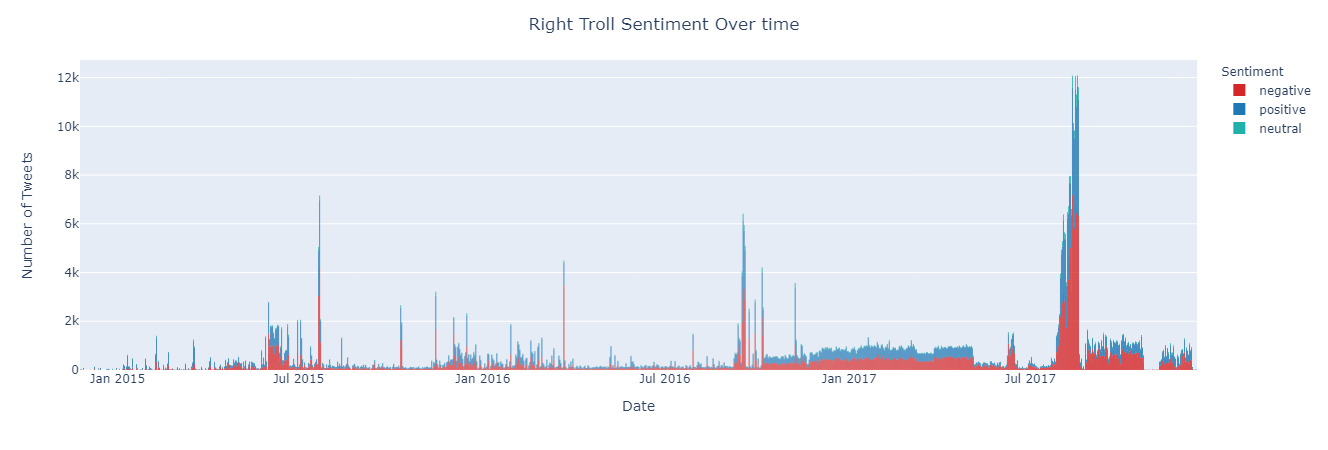

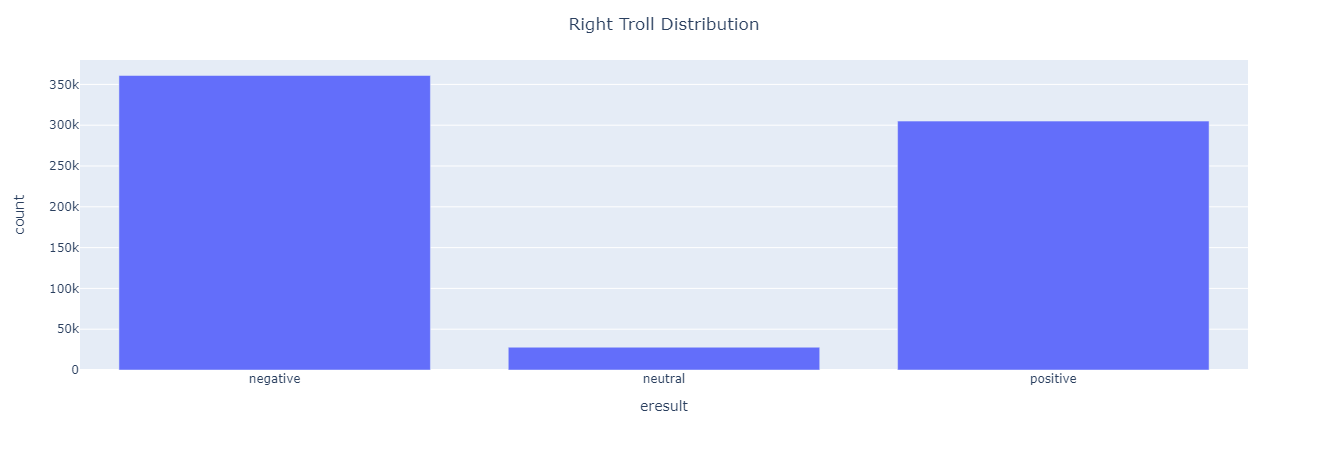

In [50]:
make_figures(_right_trolls_df, "Right Troll")

### All Trolls Create the data (takes a long time)

In [12]:
name = "all_trolls"
# run_sentiment(df_troll, name)
_all_trolls_df = load_pandas(name)

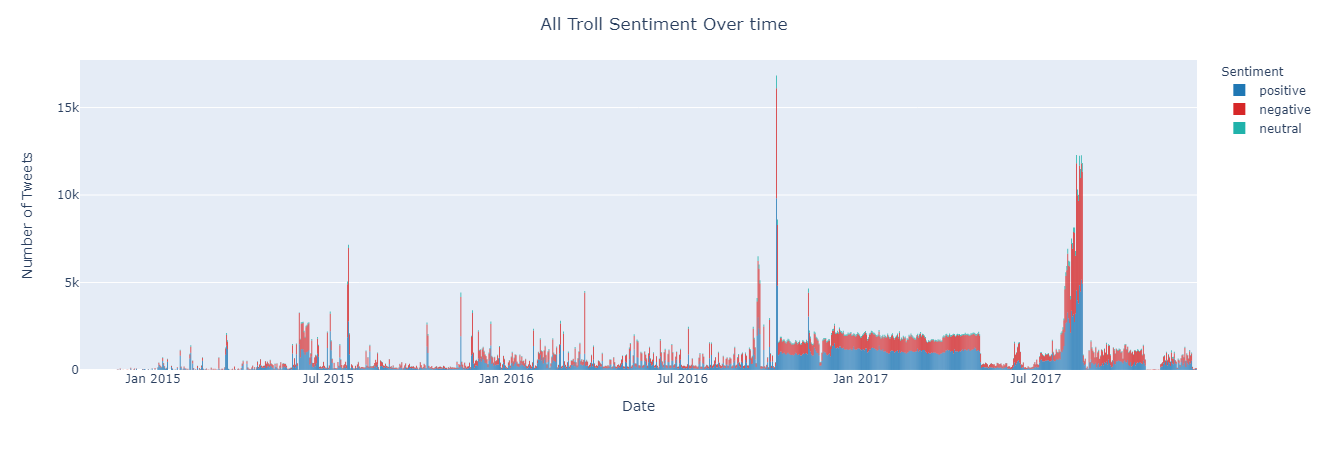

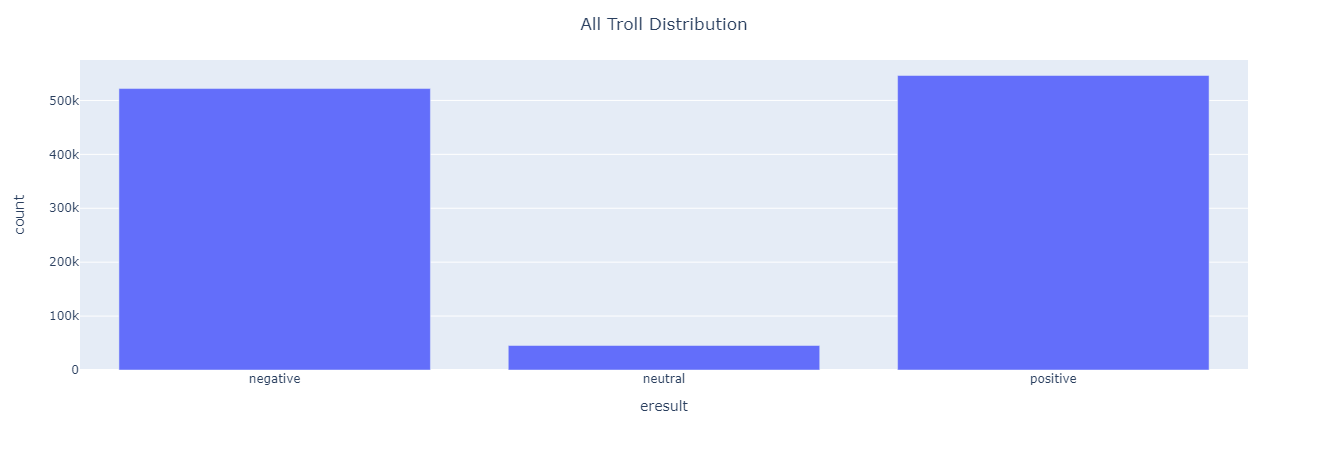

In [51]:
make_figures(_all_trolls_df, "All Troll")

### Non-Troll Create the data (takes a long time)

In [23]:
name = "non_trolls"
# run_sentiment(df_troll, name)
_non_trolls_df = load_pandas(name)

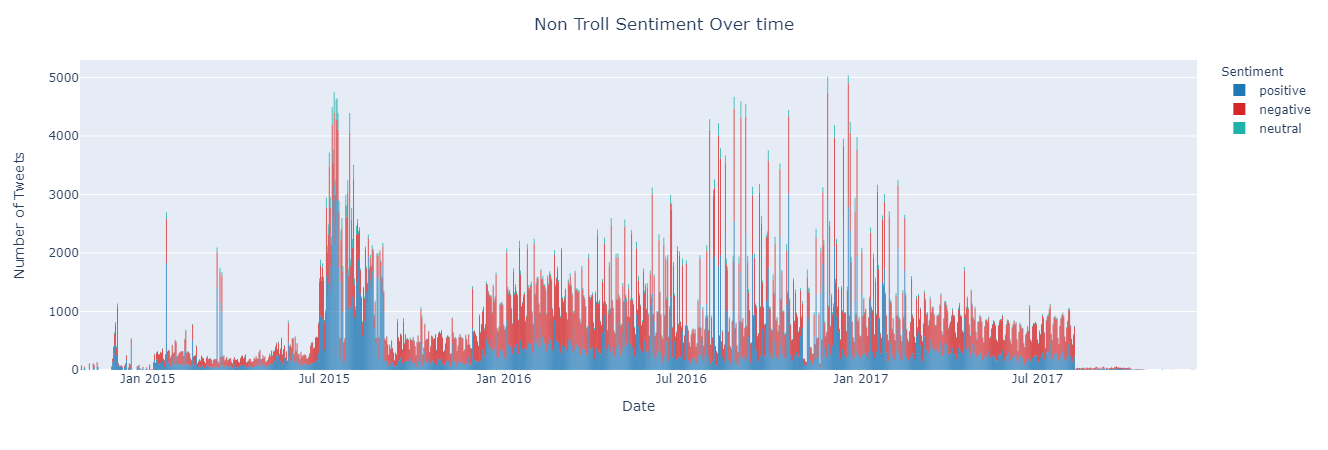

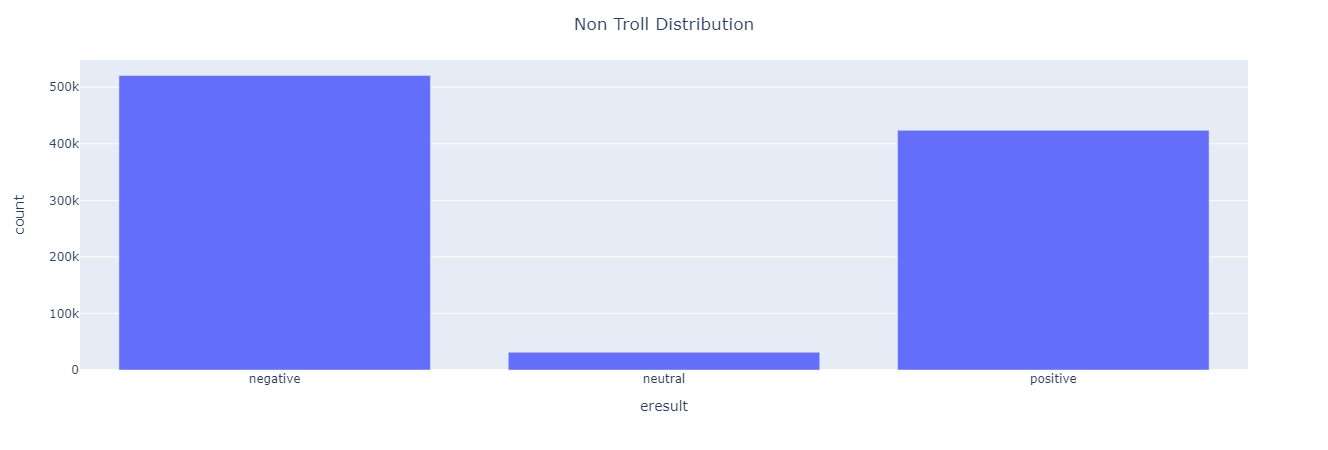

In [53]:
make_figures(_non_trolls_df, "Non Troll")